<a href="https://colab.research.google.com/github/rbarman/AnimeGANs/blob/master/Anime_face_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspiration from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
from IPython.display import Image as display_image
from google.colab import drive
drive.mount('/content/drive')
import os
import PIL
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
%matplotlib inline

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://github.com/rbarman/AnimeGANs

Cloning into 'AnimeGANs'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 127 (delta 67), reused 44 (delta 20), pack-reused 0
Receiving objects: 100% (127/127), 12.04 MiB | 2.89 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [3]:
%cd AnimeGANs/

/content/AnimeGANs


In [4]:
from my_modules import Discriminator, Generator
from device_utils import get_default_device, DeviceDataLoader, to_device
from train_utils import GANTrainer

Get Images

In [5]:
%%capture 
!unzip  /content/drive/My\ Drive/AnimeGANs/clean_images.zip

In [6]:
!ls /content/AnimeGANs/content/

clean_images


Create DataLoaders

In [7]:
ROOT_IMAGE_DIR = '/content/AnimeGANs/content/'
IMAGE_SIZE = 64
BATCH_SIZE = 128
LATENT_SIZE = 100
NUM_CHANNELS = 3
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder(ROOT_IMAGE_DIR, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*STATS)]))

In [9]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3)

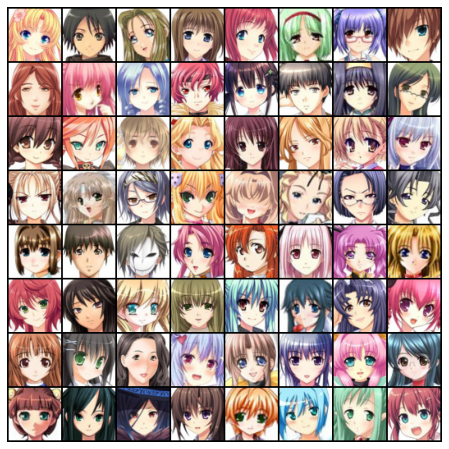

In [10]:
def show_batch(dl):
    images, _ = next(iter(dl))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    # permuting because matplotlib needs (x,y, num channels) while tensor is (num channels, x, y)
    plt.imshow(make_grid(images.detach()[0:64],padding=2,normalize=True,).permute(1,2,0));

show_batch(train_dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
# images,labels = next(iter(train_dl))
# images.shape, labels.shape

Confirm shapes with Discriminator and Generator

In [14]:
# Discriminator classifies if an image is real or not
  # input is a batch of images
  # output is a batch of results
# discriminator = Discriminator(num_features = 64)
# discriminator = to_device(discriminator, device)
# images,labels = next(iter(train_dl))

# print(f'INPUT: ',images.shape)
# out = discriminator(images)
# print('OUTPUT: ',out.shape)

In [15]:
# Generator takes a vector of noise and creates images
  # input is batch of noise/random 
  # output is a batch of images
# generator = Generator(latent_vector_len = LATENT_SIZE,num_features = 64)
# generator = to_device(generator, device)
# noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
# print(f'INPUT: ',noise.shape)
# out = generator(noise)
# print('OUTPUT: ',out.shape)

Training Loop

In [16]:
'''
pseudo code of training loop:

for epoch in epochs:
  for batch in train dataloader:
    
    # Train Discriminator
    - forward pass of {real} images to Discriminator
    - calculate loss + backwards pass

    - create batch of fake images from Generator
    - forward pass of images to Discriminator
    - calculate loss + backwards pass

    - add both gradients from both losses  + update Discriminator weights

    # Train Generator
    - foward pass of latent vector to create fake images
    - forward pass of fake images to Discriminator
    - calculate loss (how well the discrimator classifies the images are fake)
    - backwards pass + update weights
'''

'\npseudo code of training loop:\n\nfor epoch in epochs:\n  for batch in train dataloader:\n    \n    # Train Discriminator\n    - forward pass of {real} images to Discriminator\n    - calculate loss + backwards pass\n\n    - create batch of fake images from Generator\n    - forward pass of images to Discriminator\n    - calculate loss + backwards pass\n\n    - add both gradients from both losses  + update Discriminator weights\n\n    # Train Generator\n    - foward pass of latent vector to create fake images\n    - forward pass of fake images to Discriminator\n    - calculate loss (how well the discrimator classifies the images are fake)\n    - backwards pass + update weights\n'

In [17]:
# set up generator, discriminators, and optimizers

generator = Generator(100,64)
generator = to_device(generator, device)

discriminator = Discriminator(num_features = 64)
discriminator = to_device(discriminator, device)

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=.0002, betas=(0.5, 0.999))

In [18]:
gan = GANTrainer(train_dl,generator,discriminator,optimizerG,optimizerD)

Saving training session data to /content/drive/My Drive/AnimeGANs/07242020_025930/
	/content/drive/My Drive/AnimeGANs/07242020_025930/generated/ stores generated images
	/content/drive/My Drive/AnimeGANs/07242020_025930/checkpoints/ stores checkpoint weights


In [19]:
history = gan.train(num_epochs = 5)


Saved generated images to /content/drive/My Drive/AnimeGANs/07242020_025930/generated/1.png
Epoch [1/5], loss_g: 4.1895, loss_d: 0.5046, real_score: 0.7364, fake_score: 0.1288



Saved generated images to /content/drive/My Drive/AnimeGANs/07242020_025930/generated/2.png
Epoch [2/5], loss_g: 5.3397, loss_d: 0.4063, real_score: 0.8512, fake_score: 0.1844



Saved generated images to /content/drive/My Drive/AnimeGANs/07242020_025930/generated/3.png
Epoch [3/5], loss_g: 4.1575, loss_d: 0.5408, real_score: 0.6878, fake_score: 0.0244



Saved generated images to /content/drive/My Drive/AnimeGANs/07242020_025930/generated/4.png
Epoch [4/5], loss_g: 8.5886, loss_d: 0.5316, real_score: 0.9557, fake_score: 0.3382



Saved generated images to /content/drive/My Drive/AnimeGANs/07242020_025930/generated/5.png
Epoch [5/5], loss_g: 5.4807, loss_d: 0.2881, real_score: 0.9389, fake_score: 0.1830


In [20]:
gan.save_checkpoint()

Saved model and optimzer weights to /content/drive/My Drive/AnimeGANs/07242020_025930/checkpoints/epoch5.pth


Results per epoch

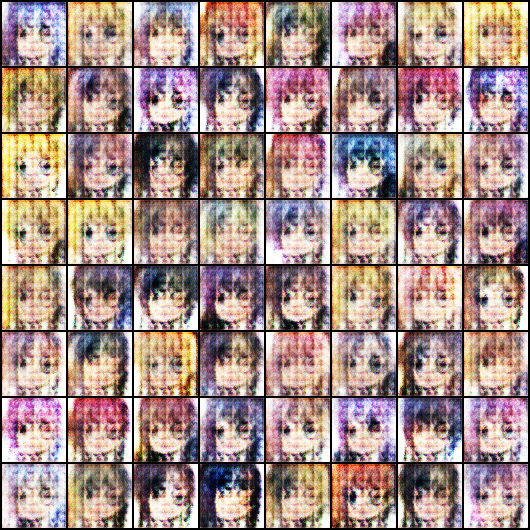

In [21]:
display_image(f'{gan.gen_dir}1.png')

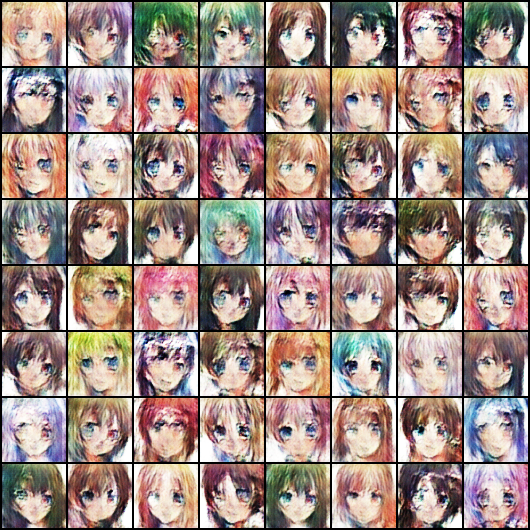

In [22]:
display_image(f'{gan.gen_dir}5.png')

In [23]:
#train 5 more epochs
history2 = gan.train(num_epochs = 5)


Saved generated images to /content/drive/My Drive/AnimeGANs/07242020_025930/generated/6.png
Epoch [1/5], loss_g: 7.4252, loss_d: 0.3426, real_score: 0.9707, fake_score: 0.2406



Saved generated images to /content/drive/My Drive/AnimeGANs/07242020_025930/generated/7.png
Epoch [2/5], loss_g: 5.9757, loss_d: 0.3607, real_score: 0.9084, fake_score: 0.1873



Saved generated images to /content/drive/My Drive/AnimeGANs/07242020_025930/generated/8.png
Epoch [3/5], loss_g: 6.8954, loss_d: 0.3321, real_score: 0.9787, fake_score: 0.2394



Saved generated images to /content/drive/My Drive/AnimeGANs/07242020_025930/generated/9.png
Epoch [4/5], loss_g: 3.2774, loss_d: 0.2369, real_score: 0.8941, fake_score: 0.0982



Saved generated images to /content/drive/My Drive/AnimeGANs/07242020_025930/generated/10.png
Epoch [5/5], loss_g: 4.8121, loss_d: 0.2851, real_score: 0.9107, fake_score: 0.1543


In [24]:
gan.save_checkpoint()

Saved model and optimzer weights to /content/drive/My Drive/AnimeGANs/07242020_025930/checkpoints/epoch10.pth


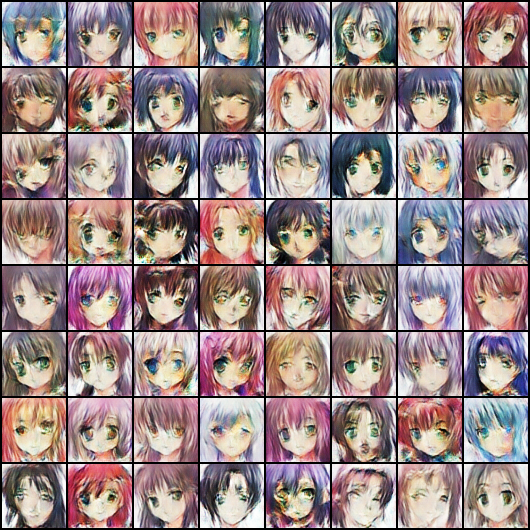

In [25]:
display_image(f'{gan.gen_dir}10.png')

- https://pytorch.org/docs/stable/tensorboard.html
- https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb#scrollTo=Po7rTfQswAMT



In [ ]:
# import imageio
# images = []
# for name in os.listdir(gan.gen_dir):
#     image = imageio.imread(f'{gan.gen_dir}{name}')
#     images.append(image)

# imageio.mimwrite('out.gif', images, format= '.gif', fps = 1)

In [ ]:
#display_image('out.gif',format='png')